## Analyse ABES embeddings - 16/05/2023

Mise à jour me 26/06/2023 suite à la deuxième itération de calcul des embeddings après avoir enlevé les concepts RAMEAU qui n'étaient ni des Tf, ni des Td

# Set project

## Import packages

In [46]:
# Import librairies
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from utils_metrics import *
from utils_visualization import *

In [47]:
# Suppression des FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Graphical parameters

In [48]:
# Parametres graphiques
%matplotlib inline
rcParams = {
    'font.size': 14,
    'font.family':'sans-serif',
    'font.sans-serif':['Liberation Sans'],
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'figure.max_open_warning': 30}

sns.set(rc=rcParams)
sns.set_style(
    "whitegrid", {
        'axes.edgecolor': 'k',
        'axes.linewidth': 1,
        'axes.grid': True,
        'xtick.major.width': 1,
        'ytick.major.width': 1
        })

sns.set_context(
    "notebook",
    font_scale=1.1,
    rc={"lines.linewidth": 1.5})

pd.set_option('display.max_columns', None)

### Paths

In [49]:
# Set paths
path = "."
os.chdir(path)
data_path = path + "/data"
data_path_embed = "/home/aurelie/ABES/labo-indexation-ai/data/embeddings/juin2023"
fig_path = path + "/figs"

# Import data

In [50]:
# Original dataset
rameau_file = "rameau_Tf_Td.csv"
test_dataset = "test_dataset.csv"
valid100_dataset = "valid100_dataset.csv"
embedding_test = "test_dataset_resu.csv"
embedding_100notices = "valid100_resu.csv"

## Check Files

In [51]:
# Import rameau list
ram = pd.read_csv(os.path.join(data_path, rameau_file))
print("Nombre de notices différentes: ", ram.shape[0])
ram.head(10)

Nombre de notices différentes:  103628


,Unnamed: 0,PPN,NOM,URI
0,0,157992527,Kirp?n,https://www.idref.fr/157992527
1,1,110140494,Militaires artistes,https://www.idref.fr/110140494
2,2,028492161,Militaires romains,https://www.idref.fr/028492161
3,3,028521757,Militaires prussiens,https://www.idref.fr/028521757
4,4,029895561,Sa-skya-pa,https://www.idref.fr/029895561
5,5,031875459,Militaires réunionnais,https://www.idref.fr/031875459
6,6,032370083,Construction à l'épreuve de la sécheresse,https://www.idref.fr/032370083
7,7,032878117,Missionnaires suisses,https://www.idref.fr/032878117
8,8,034423982,Militaires ivoiriens,https://www.idref.fr/034423982
9,9,034686940,Outils à métaux,https://www.idref.fr/034686940


In [52]:
# Import train dataset
df_train = pd.read_csv(os.path.join(data_path, "train_dataset.csv"))
df_train["PPN"] = df_train["PPN"].astype(str)
print("Dimension of the dataset: ", df_train.shape)

Dimension of the dataset:  (125264, 10)


In [53]:
# Verification de la bonne prise en compte des ";" dans les concepts
df_train[df_train['PPN'] == "187570213"]

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
36222,187570213,Le poulet en 100 recettes,Tout le monde aime le poulet ! Irrésistible lo...,Cuisine (poulet ; viande),641.665,Le poulet en 100 recettes Tout le monde aime ...,Cuisine (poulet ; viande),False,['Cuisine (poulet ; viande)'],['Cuisine (poulet ; viande)']


In [54]:
# Verification de la bonne prise en compte des ";" dans les concepts
df_train[df_train["RAMEAU"].str.contains(" ; ")]

,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
1630,003905136,Le grand refus : réflexions sur la grève de dé...,"La 4e de couv. indique : ""Les mutations économ...",Grève de la fonction publique (France ; 1995);...,331.89,Le grand refus : réflexions sur la grève de dé...,Grève de la fonction publique (France ; 1995);...,False,['Grève de la fonction publique (France ; 1995...,['Grève de la fonction publique (France ; 1995...
3063,021115753,Un développement ambigu : structure et changem...,La transformation de la Réunion en département...,Changement social;Conditions rurales;La Réunio...,NaN,Un développement ambigu : structure et changem...,Changement social;Conditions rurales;Condition...,False,"['Changement social', 'Conditions rurales', 'C...","['Changement social', 'Conditions rurales', 'C..."
8228,081324510,"Laïcité, 1905-2005 : entre passion et raison","La 4ème de couverture indique : ""La laïcité in...",Laïcisme;Laïcité;Séparation des Églises et de ...,322.1,"Laïcité, 1905-2005 : entre passion et raison L...",Laïcisme;Laïcité;Séparation des Églises et de ...,False,"['Laïcisme', 'Laïcité', ""Séparation des Église...","['Laïcisme', 'Laïcité', ""Séparation des Église..."
8750,085225037,Quand les catholiques étaient hors la loi,La 4e de couverture indique : « Les catholique...,Congrégations religieuses (droit);Laïcité;Ordr...,271.009 44,Quand les catholiques étaient hors la loi La 4...,Congrégations religieuses (droit);Laïcité;Ordr...,False,"['Congrégations religieuses (droit)', 'Laïcité...","['Congrégations religieuses (droit)', 'Laïcité..."
8886,086965085,Histoire de la laïcité à la française : loi de...,Les lois dont on parle le plus ne sont pas cel...,Laïcité;Religion et État;Séparation des Église...,322.109 4409,Histoire de la laïcité à la française : loi de...,Laïcité;Religion et État;Séparation des Église...,False,"['Laïcité', 'Religion et État', ""Séparation de...","['Laïcité', 'Religion et État', ""Séparation de..."
...,...,...,...,...,...,...,...,...,...,...
121280,266381804,Cuisiner le chevreuil : 50 recettes,La viande de chevreuil est sans doute la plus ...,Cuisine (chevreuil ; viande),641.691,Cuisiner le chevreuil : 50 recettes La viande ...,Cuisine (chevreuil ; viande),False,['Cuisine (chevreuil ; viande)'],['Cuisine (chevreuil ; viande)']
121651,266605729,Les carnets de Charlie,Il existe des dessinateurs dont les dessins so...,Attentats contre Charlie hebdo et l'Hyper Cach...,363.325 0944090512,Les carnets de Charlie Il existe des dessinate...,Attentats contre Charlie hebdo et l'Hyper Cach...,True,"[""Attentats contre Charlie hebdo et l'Hyper Ca...","[""Attentats contre Charlie hebdo et l'Hyper Ca..."
122445,267170637,La cathédrale immortelle,"Que brûle une ancienne cathédrale, et soudain ...","Incendie de Notre-Dame (Paris, France ; 2019)",723,La cathédrale immortelle Que brûle une ancien...,"Incendie de Notre-Dame (Paris, France ; 2019)",False,"['Incendie de Notre-Dame (Paris, France ; 2019)']","['Incendie de Notre-Dame (Paris, France ; 2019)']"
123050,267548672,La naissance des Brigades internationales : ré...,"Retrouvé dans les archives ex-soviétiques, ce ...",Brigades internationales (Espagne ; 1936-1938),NaN,La naissance des Brigades internationales : ré...,Brigades internationales (Espagne ; 1936-1938),False,['Brigades internationales (Espagne ; 1936-193...,['Brigades internationales (Espagne ; 1936-193...


In [55]:
# Import test dataset
df_test = pd.read_csv(os.path.join(data_path, test_dataset))
df_test["PPN"] = df_test["PPN"].astype(str)
print("Dimension of the dataset: ", df_test.shape)
df_test.head()

Dimension of the dataset:  (29244, 10)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
0,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme']
1,000057525,La théorie des jeux et ses applications à l'éc...,La théorie des jeux occupe au sein des mathéma...,Mathématiques économiques;Théorie des jeux,519.3,La théorie des jeux et ses applications à l'éc...,Mathématiques économiques;Théorie des jeux,False,"['Mathématiques économiques', 'Théorie des jeux']","['Mathématiques économiques', 'Théorie des jeux']"
2,000079472,Pétrole : le vrai dossier,Que dissimulent les événements que nous avons ...,Crise économique (1973),320,Pétrole : le vrai dossier Que dissimulent les ...,Crise économique (1973),False,['Crise économique (1973)'],['Crise économique (1973)']
3,000085642,Magie : aspects de la tradition occidentale,La magie se situe au cœur de la tradition occu...,Magie,100,Magie : aspects de la tradition occidentale La...,Magie,False,['Magie'],['Magie']
4,000087637,Mathématiques de base pour les linguistes,La fonction essentielle de ce livre est de fai...,Linguistique -- Méthodes graphiques;Linguistiq...,510,Mathématiques de base pour les linguistes La f...,Linguistique -- Méthodes graphiques;Linguistiq...,True,"['Linguistique -- Méthodes graphiques', 'Lingu...","['Linguistique', 'Méthodes graphiques', 'Lingu..."


In [56]:
# Check import for embeddings
pattern = r';;\s*(?![^()$]*\))| -- |-- | --|--| - '
emb_test = pd.read_csv(
    os.path.join(data_path_embed, embedding_test))
# Temporaire : remove NaN 
emb_test = emb_test.dropna()
# Rename columns
emb_test.rename(columns={"ppn" : "PPN", "label": "embedding_chains"}, inplace=True)
emb_test["embeddings_autorites"] = emb_test["embedding_chains"].apply(lambda x: re.split(pattern, str(x)))
emb_test.head(20)

,PPN,score,embedding_chains,embeddings_autorites
0,00002564X,0.797401,Innovation -- Philosophie,"[Innovation, Philosophie]"
1,00002564X,0.779297,Innovation -- Aspect social,"[Innovation, Aspect social]"
2,00002564X,0.775827,Technique -- Aspect social,"[Technique, Aspect social]"
3,00002564X,0.774429,Prévision technologique,[Prévision technologique]
4,00002564X,0.773781,Technique et civilisation,[Technique et civilisation]
5,00002564X,0.770500,Philosophie de la technique,[Philosophie de la technique]
6,000057525,0.801763,Mathématiques économiques,[Mathématiques économiques]
7,000057525,0.764727,Économétrie,[Économétrie]
8,000057525,0.761931,Modèles mathématiques,[Modèles mathématiques]
9,000057525,0.759410,Modèles économétriques,[Modèles économétriques]


In [57]:
def flatten(list):
    flat_list = [item for sublist in list for item in sublist]
    return flat_list

In [58]:
keywords = flatten(emb_test["embeddings_autorites"])
chaines = emb_test["embedding_chains"]
print(f"Le dataset contient: \n - {len(set(keywords))} autorités RAMEAU differentes \n - {len(chaines.unique())} chaines d'indexation différentes")

Le dataset contient: 
 - 14277 autorités RAMEAU differentes 
 - 27541 chaines d'indexation différentes


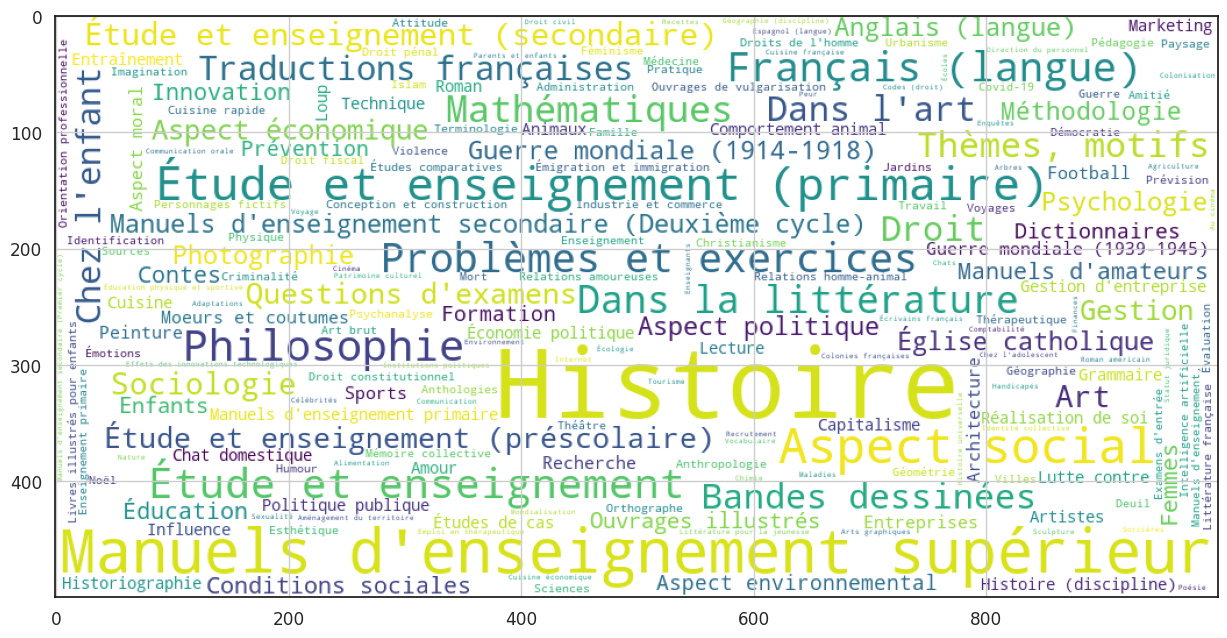

In [59]:
# Get list of labels
plot_wordcloud(
    keywords,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_autorites.png",
)

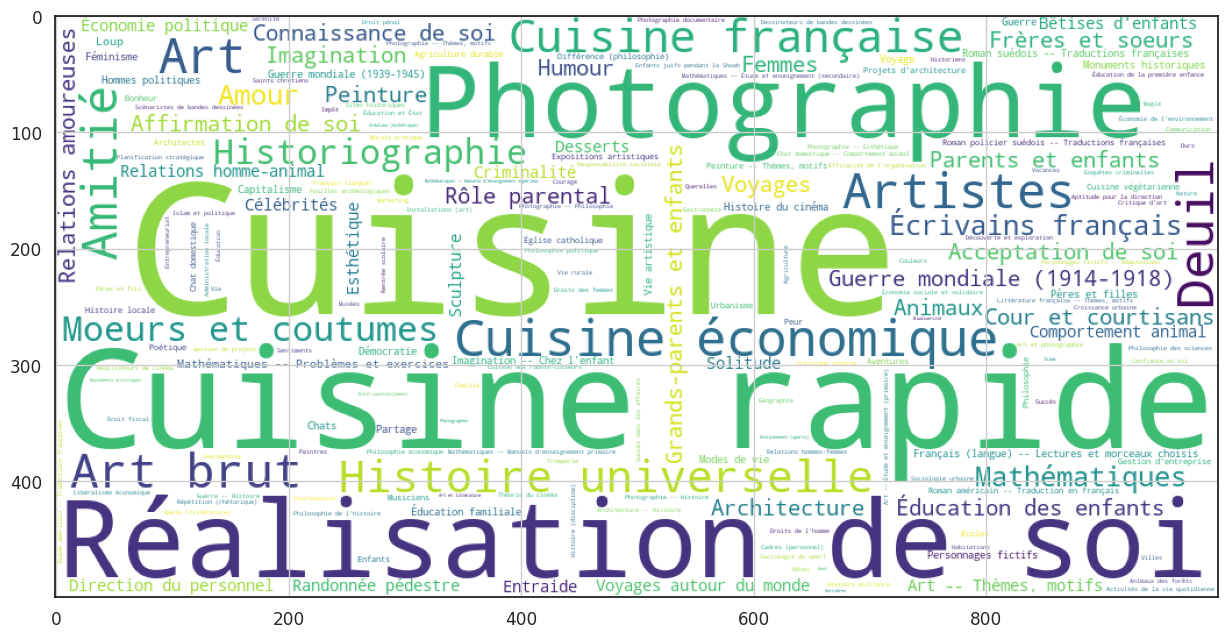

In [60]:
# Get list of chaines
plot_wordcloud(
    chaines,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_chaines.png",
)

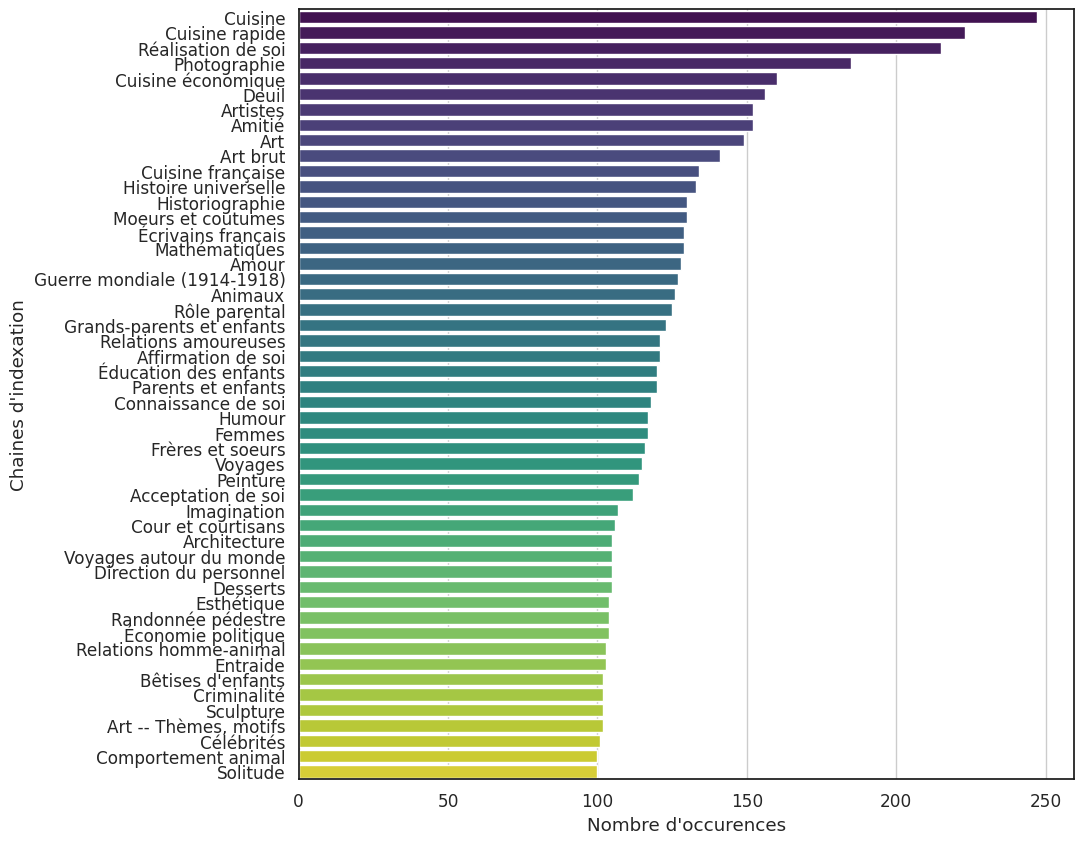

In [61]:
# Barplot of indexation chains
plot_barplot_of_tags(chaines, nb_of_tags=50, ylabel="Chaines d'indexation", figsize=(10,10))

In [62]:
# check that all labels belongs to rameau
# Verification que toutes les vedettes appartiennent au referenciel RAMEAU
RAMEAU = ram["NOM"].to_list()

unknown_concepts = []
check = [item in RAMEAU for item in keywords]
if all(check):
    print("Tous les mots clés sont des concepts rameau")
else:
    bad_keywords = []
    for i in range(len(check)):
        if not check[i]:
            bad_keywords.append(keywords[i])
 
    unknown_concepts = list(set(bad_keywords))
    print(f"{len(unknown_concepts)} mots clés absents du répertoire RAMEAU sur un total de {len(set(keywords))}")
    

KeyboardInterrupt: 

In [ ]:
# Save list of badly formatted concepts, for check
if unknown_concepts:
    with open(os.path.join(data_path, "concepts_a_verifier_embeddingfile_juin2023.txt"), "w") as output:
        output.write(str(unknown_concepts))
    unknown_concepts

## Compute all labels for all notices

In [63]:
chains_emb_test = pd.DataFrame(emb_test.groupby("PPN")["embedding_chains"].apply(lambda x: ','.join(x).split(","))).reset_index()
chains_emb_test

,PPN,embedding_chains
0,00002564X,"[Innovation -- Philosophie, Innovation -- Aspe..."
1,000057525,"[Mathématiques économiques, Économétrie, Modèl..."
2,000079472,"[Pétrole, Gisements pétrolifères, Pétrole -- I..."
3,000085642,"[Magie -- Histoire, Magie chrétienne, Magie an..."
4,000087637,[Français (langue) -- Morphologie (linguistiqu...
...,...,...
29239,268996237,"[Microorganismes, Bactéries, Microbiologie, Di..."
29240,268996970,"[Mangas -- Traductions françaises, Mères et en..."
29241,268998078,"[Rentrée scolaire, Jeux d'extérieur, Écoles ma..."
29242,268998485,"[Méthode Montessori, Activités d'éveil (premiè..."


In [64]:
# Compute list of RAMEAU concepts present in each embedding chains
chains_emb_test["embeddings_autorites"] = chains_emb_test["embedding_chains"].apply(lambda x: flatten([y.split(' -- ') for y in x]))
chains_emb_test

,PPN,embedding_chains,embeddings_autorites
0,00002564X,"[Innovation -- Philosophie, Innovation -- Aspe...","[Innovation, Philosophie, Innovation, Aspect s..."
1,000057525,"[Mathématiques économiques, Économétrie, Modèl...","[Mathématiques économiques, Économétrie, Modèl..."
2,000079472,"[Pétrole, Gisements pétrolifères, Pétrole -- I...","[Pétrole, Gisements pétrolifères, Pétrole, Ind..."
3,000085642,"[Magie -- Histoire, Magie chrétienne, Magie an...","[Magie, Histoire, Magie chrétienne, Magie anti..."
4,000087637,[Français (langue) -- Morphologie (linguistiqu...,"[Français (langue), Morphologie (linguistique)..."
...,...,...,...
29239,268996237,"[Microorganismes, Bactéries, Microbiologie, Di...","[Microorganismes, Bactéries, Microbiologie, Di..."
29240,268996970,"[Mangas -- Traductions françaises, Mères et en...","[Mangas, Traductions françaises, Mères et enfa..."
29241,268998078,"[Rentrée scolaire, Jeux d'extérieur, Écoles ma...","[Rentrée scolaire, Jeux d'extérieur, Écoles ma..."
29242,268998485,"[Méthode Montessori, Activités d'éveil (premiè...","[Méthode Montessori, Activités d'éveil (premiè..."


## Export data

In [65]:
# save to csv
chains_emb_test.to_csv(os.path.join(data_path_embed, "test_dataset_embeddings_results.csv"))

## Same process for valid test

Le dataset contient: 
 - 558 autorités RAMEAU differentes 
 - 578 chaines d'indexation différentes
Tous les mots clés sont des concepts rameau


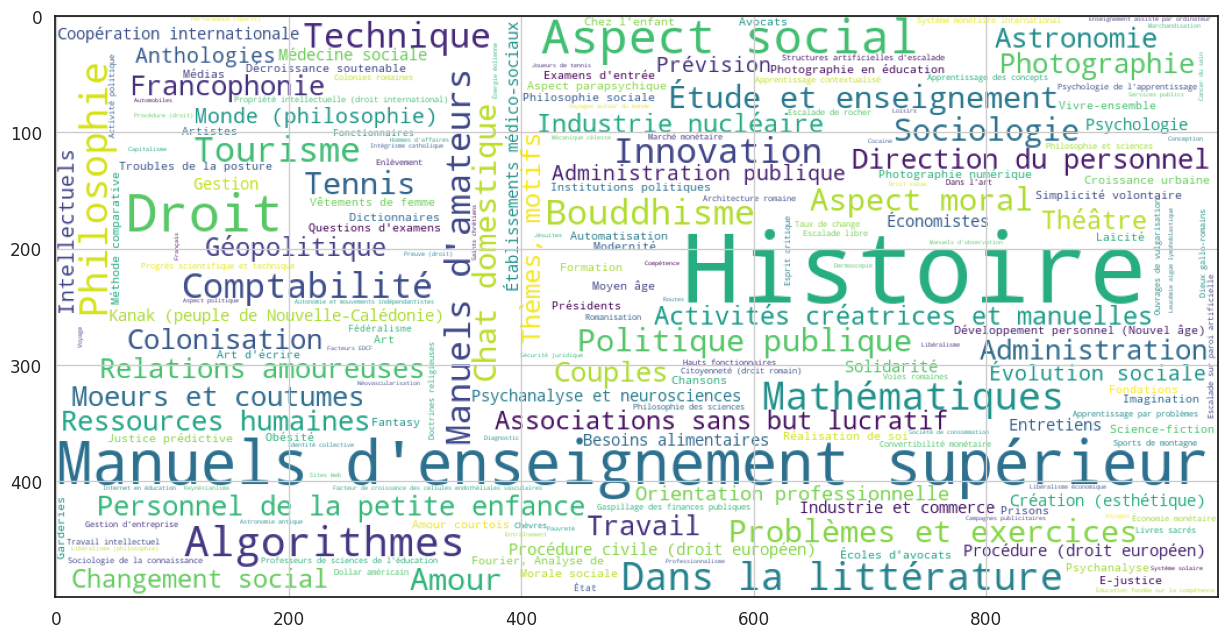

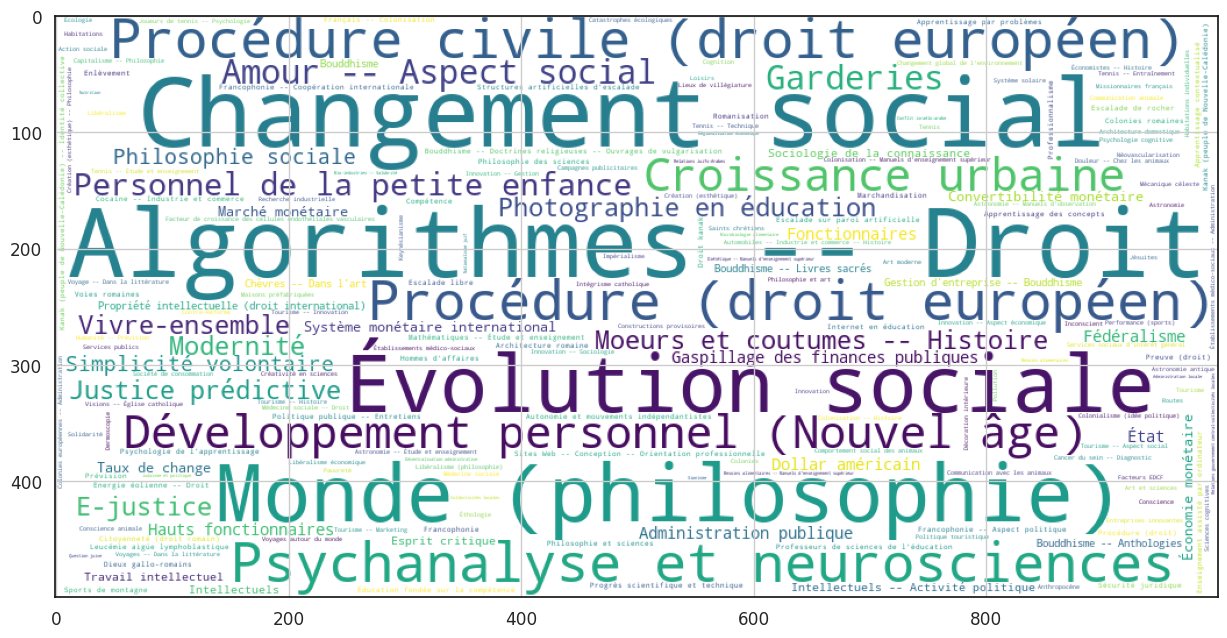

In [66]:
# Check import for embeddings
emb_valid = pd.read_csv(
    os.path.join(data_path_embed, embedding_100notices))
emb_valid = emb_valid.dropna()
emb_valid.rename(columns={"ppn" : "PPN", "label": "embedding_chains"}, inplace=True)
emb_valid["embeddings_autorites"] = emb_valid["embedding_chains"].apply(lambda x: re.split(pattern, str(x)))
keywords_valid = flatten(emb_valid["embeddings_autorites"])
chaines_valid = emb_valid["embedding_chains"]
print(f"Le dataset contient: \n - {len(set(keywords_valid))} autorités RAMEAU differentes \n - {len(chaines_valid.unique())} chaines d'indexation différentes")

# Get list of labels
plot_wordcloud(
    keywords_valid,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_autorites_validation_dataset.png",
)
# Get list of chaines
plot_wordcloud(
    chaines_valid,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_chaines_validation_dataset.png",
)

# Verification que toutes les vedettes appartiennent au referenciel RAMEAU
unknown_concepts_valid = []
check = [item in RAMEAU for item in keywords_valid]
if all(check):
    print("Tous les mots clés sont des concepts rameau")
else:
    bad_keywords_valid = []
    for i in range(len(check)):
        if not check[i]:
            bad_keywords_valid.append(keywords[i])
 
    unknown_concepts_valid = list(set(bad_keywords_valid))
    print(f"{len(unknown_concepts_valid)} mots clés absents du répertoire RAMEAU sur un total de {len(set(keywords_valid))}")

# Save list of badly formatted concepts, for check
if unknown_concepts_valid:
    with open(os.path.join(data_path, "concepts_a_verifier_embeddingfile_valid100_juin2023.txt"), "w") as output:
        output.write(str(unknown_concepts_valid))
    print("Concepts inconnus du répertoire RAMEAU :\n", unknown_concepts_valid)

chains_emb_valid = pd.DataFrame(emb_valid.groupby("PPN")["embedding_chains"].apply(lambda x: ','.join(x).split(","))).reset_index()
chains_emb_valid["embeddings_autorites"] = chains_emb_valid["embedding_chains"].apply(lambda x: flatten([y.split(' -- ') for y in x]))

# save to csv
chains_emb_valid.to_csv(os.path.join(data_path_embed, "valid100_dataset_embeddings_results.csv"))

## Merge Sudoc et embeddings

In [67]:
# Check notices extraction 
df = df_test.merge(emb_test, on="PPN", how="inner")
print("Dimension after merge: ", df.shape)
df.head()

Dimension after merge:  (175441, 13)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts,score,embedding_chains,embeddings_autorites
0,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.797401,Innovation -- Philosophie,"[Innovation, Philosophie]"
1,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.779297,Innovation -- Aspect social,"[Innovation, Aspect social]"
2,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.775827,Technique -- Aspect social,"[Technique, Aspect social]"
3,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.774429,Prévision technologique,[Prévision technologique]
4,00002564X,La révolution structurale,"Mutations ou crises, les brusques accès de fiè...",Structuralisme,100,"La révolution structurale Mutations ou crises,...",Structuralisme,False,['Structuralisme'],['Structuralisme'],0.773781,Technique et civilisation,[Technique et civilisation]


In [68]:
df.to_csv(os.path.join(data_path,"df_test_with_embeddings.csv"))

## Multilabel classification - Metrics

In [69]:
from sklearn.preprocessing import MultiLabelBinarizer

### Indexation chains

#### Create binarizer

In [70]:
# Import origianl data
orig = pd.read_pickle(os.path.join(data_path, "working_data_sans_dewey.pkl"))
print("Original dataset: ", orig.shape)
orig.head(3)

Original dataset:  (154508, 10)


,PPN,TITRE,RESUME,RAMEAU,DEWEY,DESCR,RAMEAU_CHECKED,presence_chaine_indexation,rameau_chaines_index,rameau_concepts
0,000002364,La culture pour vivre,Mort de la culture populaire en France. Mutati...,Culture populaire;Diffusion de la culture;Poli...,840,La culture pour vivre Mort de la culture popul...,Culture populaire;Diffusion de la culture;Poli...,False,"[Culture populaire, Diffusion de la culture, P...","[Culture populaire, Diffusion de la culture, P..."
1,000014877,"La nuit, le jour : essai psychanalytique sur l...","Discontinuité, latence, rétablissement d’une c...",Complexe de castration;Psychanalyse;Rêves,154.63,"La nuit, le jour : essai psychanalytique sur l...",Complexe de castration;Psychanalyse;Rêves,False,"[Complexe de castration, Psychanalyse, Rêves]","[Complexe de castration, Psychanalyse, Rêves]"
2,000021857,"Ruptures, cultures","Il faut imaginer Robinson sur son île, au mome...",Culture,840,"Ruptures, cultures Il faut imaginer Robinson s...",Culture,False,[Culture],[Culture]


In [71]:
# Create chaines_binarizer
chaines_orig = flatten(orig["rameau_chaines_index"])

chaines_orig = set(chaines_orig)
print(f"Il y a {len(chaines_orig)} chaines d'indexation différentes dans le jeu d'entrainement")

Il y a 68674 chaines d'indexation différentes dans le jeu d'entrainement


In [72]:
# Multilabel binarizer
mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit([chaines_orig])

MultiLabelBinarizer()

In [73]:
# Check classes
print("Nombre de classes: ", len(mlb.classes_))
mlb.classes_

Nombre de classes:  68674


array(['', "'Ndrangheta", "'Ūd, Musique d' -- Histoire", ...,
       'Îles -- Représentations sociales', 'Îlot thermique urbain',
       'Îlots urbains'], dtype=object)

#### Binarize Sudoc indexation chains and embeddings chains

In [74]:
# Binarization on sudoc chains
sudoc = mlb.transform(df["rameau_chaines_index"].apply(lambda x: eval(x)))
# Check classes
mlb.inverse_transform(sudoc[0:5])

[('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',)]

In [75]:
# Binarization on embedding chains
embed = mlb.transform(df["embedding_chains"].apply(lambda x: [x]))
# Check classes
mlb.inverse_transform(embed[0:5])

[('Innovation -- Philosophie',),
 ('Innovation -- Aspect social',),
 ('Technique -- Aspect social',),
 ('Prévision technologique',),
 ('Technique et civilisation',)]

### Concepts

#### Create binarizer

In [76]:
# Create chaines_binarizer
concepts_orig = ram["NOM"]
print(f"Il y a {len(concepts_orig)} concepts RAMEAU différents dans le jeu d'entrainement")

Il y a 103628 concepts RAMEAU différents dans le jeu d'entrainement


In [77]:
# Multilabel binarizer
mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit([concepts_orig])

MultiLabelBinarizer()

In [78]:
# Check classes
mlb.classes_

array(['!Xóõ (langue)',
       '"Sprach- und Sachatlas Italiens und der Südschweiz"',
       '"Taalatlas van Noord- en Zuid-Nederland"', ..., 'Ḥawfi', 'Ṭhumrī',
       'Ṭār (tambour), Musique de'], dtype=object)

#### Binairize Sudoc concepts and embedding concepts

In [79]:
# Binarization on sudoc chains
sudoc_concepts = mlb.transform(df["rameau_concepts"].apply(lambda x: eval(x)))
# Check classes
mlb.inverse_transform(sudoc_concepts[0:20])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


[('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',),
 ('Structuralisme',),
 ('Mathématiques économiques', 'Théorie des jeux'),
 ('Mathématiques économiques', 'Théorie des jeux'),
 ('Mathématiques économiques', 'Théorie des jeux'),
 ('Mathématiques économiques', 'Théorie des jeux'),
 ('Mathématiques économiques', 'Théorie des jeux'),
 ('Mathématiques économiques', 'Théorie des jeux'),
 ('Crise économique (1973)',),
 ('Crise économique (1973)',),
 ('Crise économique (1973)',),
 ('Crise économique (1973)',),
 ('Crise économique (1973)',),
 ('Crise économique (1973)',),
 ('Magie',),
 ('Magie',)]

In [80]:
# Binarization on embedding chains
embed_concepts = mlb.transform(df["embeddings_autorites"])
# Check classes
mlb.inverse_transform(embed_concepts[0:20])

[('Innovation', 'Philosophie'),
 ('Aspect social', 'Innovation'),
 ('Aspect social', 'Technique'),
 ('Prévision technologique',),
 ('Technique et civilisation',),
 ('Philosophie de la technique',),
 ('Mathématiques économiques',),
 ('Économétrie',),
 ('Modèles mathématiques',),
 ('Modèles économétriques',),
 ('Systèmes dynamiques',),
 ('Théorie des jeux',),
 ('Pétrole',),
 ('Gisements pétrolifères',),
 ('Aspect politique', 'Industrie et commerce', 'Pétrole'),
 ('Aspect économique', 'Industrie et commerce', 'Pétrole'),
 ('Histoire', 'Industrie et commerce', 'Pétrole'),
 ('Aspect politique', 'Pétrole', 'Réserves'),
 ('Histoire', 'Magie'),
 ('Magie chrétienne',)]

In [ ]:
####

In [81]:
# Compute metrics (takes very long time : ~1h)
results = dict()
results["Embeddings_rameau_concepts"] = label_metrics_report("Embeddings", sudoc_concepts, embed_concepts, zero_division=0)

In [ ]:
results["Embeddings_chaines_indexation"] = label_metrics_report("Embeddings", sudoc, embed, zero_division=0)

### Dataframe of results

In [27]:
result_df = pd.DataFrame(results).T
result_df

,Hamming Loss,Brier Loss,Accuracy,Precision - Macro,Recall - Macro,F1_Score - Macro,Jaccard - Macro,Precision - Sample,Recall - Sample,F1_Score - Sample,Jaccard - Sample,Precision,Recall,F1-measure,Jaccard
Embeddings_Chaines indexation,0.009777,NaN,0.0,0.092179,0.093575,0.092179,0.090782,0.115,0.339524,0.15893,0.098346,"{'Macro': 0.09217877094972067, 'Micro': 0.1142...","{'Macro': 0.0935754189944134, 'Micro': 0.29487...","{'Macro': 0.09217877094972067, 'Micro': 0.1646...","{'Macro': 0.09078212290502793, 'Micro': 0.0897..."
Embeddings_Autorités,0.011038,NaN,0.0,0.130312,0.142965,0.131054,0.123264,0.160989,0.465274,0.221226,0.138919,"{'Macro': 0.13031205464641996, 'Micro': 0.1604...","{'Macro': 0.14296455424274976, 'Micro': 0.3898...","{'Macro': 0.13105393353513656, 'Micro': 0.2273...","{'Macro': 0.12326411266260891, 'Micro': 0.1282..."


### Plot

In [28]:
# Plot results
metrics_radar_plot(
    result_df,
    remove_identity=True,
    title="Comparaison SUDOC - Embeddings - June 2023",
    savefig="metrics_embeddings-sudoc.html",)

IndexError: list index out of range